# Swiss roll data generation with DDPM

The objective of this exercise is to build a generative model from some representative examples of the distribution. We will place ourselves in the case of 2D data (2 dimensional vectors) which follow a Swiss Roll type distribution and will use Denoising Diffusion Probabilistic Models.

The reference article on the method used is : Denoising Diffusion Probabilistic Models, Jonathan Ho, Ajay Jain, Pieter Abbeel,   arXiv:2006.11239v2
https://doi.org/10.48550/arXiv.2006.11239. PDF available at : https://arxiv.org/abs/2006.11239

Let's start by importing the different modules needed.

In [126]:
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import torch.optim as optim

import matplotlib.pyplot as plt
%matplotlib inline
import torch.optim as optim
import numpy.random as rnd

We will generate the data using the Scikit-Learn library's Swiss Roll data generator and then create a PyTorch dataset to use them subsequently.

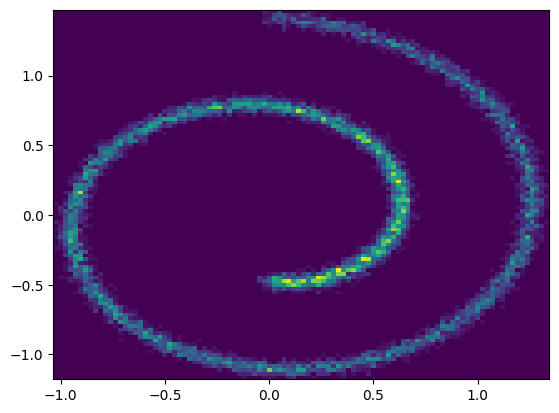

In [127]:
import sklearn.datasets
srx,sry = sklearn.datasets.make_swiss_roll(n_samples=10000, noise=0.3, random_state=None)
srx=torch.tensor(srx,dtype=torch.float)
x_train = torch.cat((srx[:,0].reshape(-1,1),srx[:,2].reshape(-1,1)),1)/10
plt.hist2d(x_train[:,0].numpy(),x_train[:,1].numpy(),bins=100)


class my_dataset(Dataset):
    def __init__(self,x):
      self.x=x
    def __len__(self):
        return self.x.shape[0]

    def __getitem__(self, idx):
        return self.x[idx]
x_train_dataset = my_dataset(x_train)
hidden_dim=2


In the following code cell, we will define the different parameters useful for generating increasingly noisy data sequences. You can refer back to the course or article to list these parameters, but it is about defining T which is the number of time steps and alpha which is the noise level between two time steps. You will plot the curve that shows the evolution of alpha and the cumulative product of alphas over time.

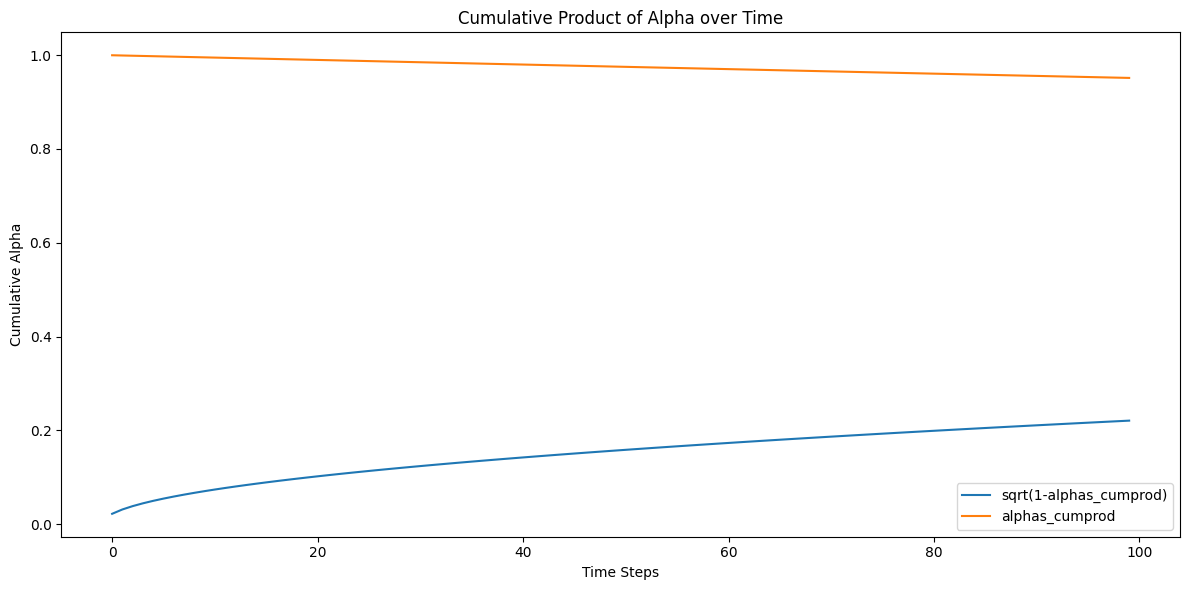

In [128]:
# definition of the timesteps, betas, alphas, etc.

T = 100;

beta_0 = 0.0005;
betas = beta_0 * torch.ones(1,T);

alphas = 1 - betas;

epsilon = rnd.randn(1);

alphas_cumprod = np.cumprod(alphas);

# Plot the evolution of alpha
plt.figure(figsize=(12, 6))
plt.plot(torch.sqrt(1-alphas_cumprod), label = "sqrt(1-alphas_cumprod)")
plt.title('Evolution of Alpha over Time')
plt.xlabel('Time Steps')
plt.ylabel('Alpha')


# Plot the cumulative product of alpha
plt.plot(alphas_cumprod, label = "alphas_cumprod")
plt.title('Cumulative Product of Alpha over Time')
plt.xlabel('Time Steps')
plt.ylabel('Cumulative Alpha')
plt.legend()
# Show the plots
plt.tight_layout()
plt.show()


We will now take the riginal training data (data that is not noisy) and apply the noise model to them. Plot the data in 2D every 10 time steps. At the last time step, these data should no longer be distinguishable from 2D Gaussian noise.

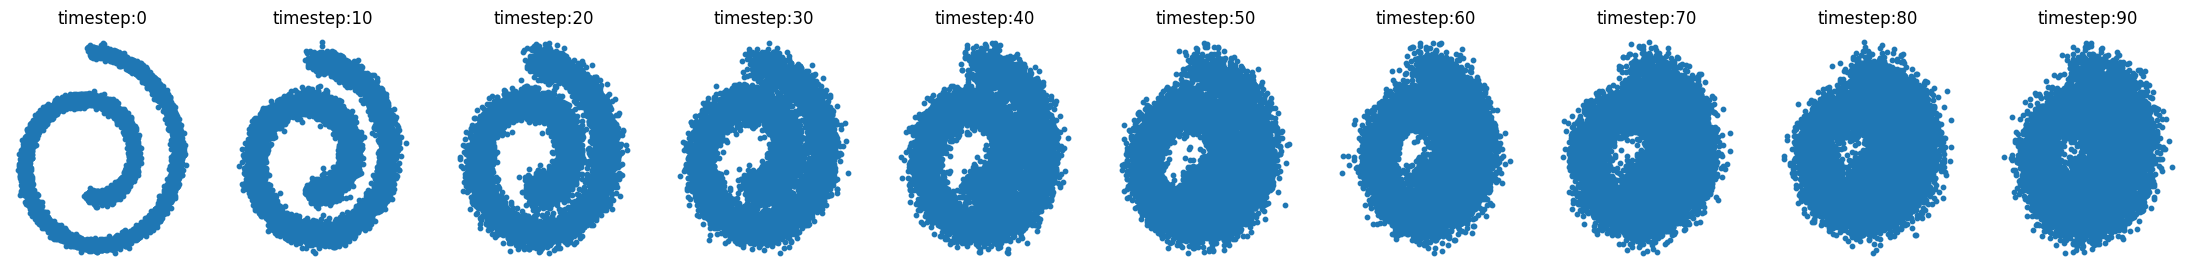

In [129]:
# visualisation of the forward diffusion process


def forward(x_0, t, noise=None):
    if noise is None:
      noise = torch.randn_like(x_0)
    x_t = torch.sqrt(alphas_cumprod[t]) * x_0 + torch.sqrt(1 - alphas_cumprod[t]) * noise
    return x_t, noise


def plot_diffusion():
    fig, axs = plt.subplots(1, 10, figsize=(28, 3))
    for i in range(10):
        q_i, noise = forward(x_train, torch.tensor([i * 10]))
        axs[i].scatter(q_i[:, 0], q_i[:, 1], s=10);
        axs[i].set_axis_off(); axs[i].set_title('timestep:'+str(i*10))
plot_diffusion()

Let's define a simple neural network for denoising the data.

In [130]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class DenoisingNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(DenoisingNet, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Example usage:
# Assuming input dimension is 2, hidden dimension is 64, and output dimension is 2
input_dim = 2
hidden_dim = 64
output_dim = 2

# Create an instance of the denoising network
denoising_net = DenoisingNet(input_dim, hidden_dim, output_dim)

# Assuming x is your input data (replace this with your actual data)
x = torch.randn(100, input_dim)

# Forward pass
output = denoising_net(x)

# Print the output shape
print("Output shape:", output.shape)


Output shape: torch.Size([100, 2])


And now train the denoising model.

In [132]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Assuming x_train and y_train are your noisy input data and clean target data
# You should replace these with your actual data
x_train = torch.randn(100, input_dim)
y_train = torch.randn(100, output_dim)

# Create a DataLoader
batch_size = 100
loader = torch.utils.data.DataLoader(x_train_dataset,batch_size,shuffle=True)

# Assuming you have a DenoisingNet named 'denoising_net'
# You should replace this with your actual network instance

# Define the loss function (e.g., Mean Squared Error)
criterion = nn.MSELoss()

# Define the optimizer (e.g., Stochastic Gradient Descent)
optimizer = optim.SGD(denoising_net.parameters(), lr=0.01)

# Number of training epochs
num_epochs = 1001

for epoch in range(num_epochs):
    for index, x_batch in enumerate(loader):
        # Zero the gradients
        optimizer.zero_grad()

        t = np.random.randint(0,T-1)
        noisy_x, noise = forward(x_batch,t)

        # Forward pass
        output = denoising_net(noisy_x)

        # Compute the loss
        loss = criterion(output, noise)

        # Backward pass
        loss.backward()

        # Update the weights
        optimizer.step()

    # Print loss every 100 steps
    if epoch % 100 == 0:
        print(f'Epoch [{epoch}/{num_epochs}], Step [{index}/{len(loader)}], Loss: {loss.item()}')

# Save the trained model if needed
torch.save(denoising_net.state_dict(), 'denoising_model.pth')


Epoch [0/1001], Step [99/100], Loss: 0.8216645121574402
Epoch [100/1001], Step [99/100], Loss: 0.7330921292304993
Epoch [200/1001], Step [99/100], Loss: 0.9125188589096069
Epoch [300/1001], Step [99/100], Loss: 1.0639605522155762
Epoch [400/1001], Step [99/100], Loss: 0.7453975677490234
Epoch [500/1001], Step [99/100], Loss: 0.6893906593322754
Epoch [600/1001], Step [99/100], Loss: 0.7100822925567627
Epoch [700/1001], Step [99/100], Loss: 0.7934213280677795
Epoch [800/1001], Step [99/100], Loss: 0.8648567199707031
Epoch [900/1001], Step [99/100], Loss: 0.9118640422821045
Epoch [1000/1001], Step [99/100], Loss: 0.6494415402412415


Once the model is trained, you can use it to denoise gaussian noise, and generate data.

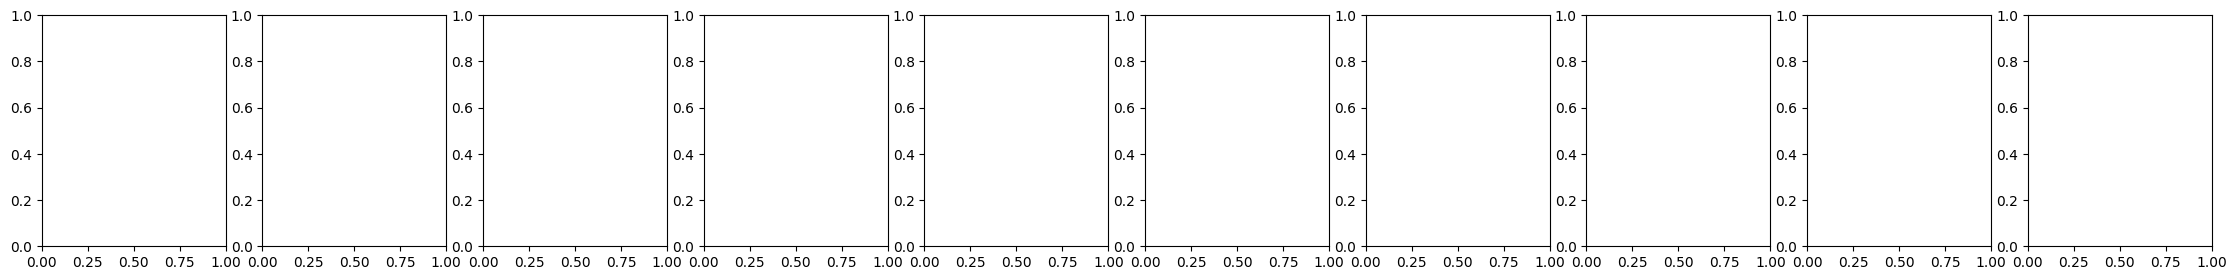

In [141]:
import torch

def denoise(model, input_data):
    # Set the model to evaluation mode
    model.eval()

    # Assuming input_data is a tensor with shape (batch_size, input_dim)
    with torch.no_grad():
        output_data = model(input_data)

    return output_data

x_test = torch.randn_like(x_train)

# Applying the denoising model to the noisy data
denoised_data = denoise(denoising_net, x_test)

# Plotting the denoised sequences
fig, axs = plt.subplots(1, 10, figsize=(28, 3))
for i in range(T,1):
    cur_x = denoised_data[i]
    cur_x = cur_x.view(-1, 2)  # Reshape to a 2-dimensional tensor if needed
    axs[i].scatter(cur_x[:, 0], cur_x[:, 1], s=2)
    axs[i].set_title('time step:' + str((i + 1) * 10))



---

# The following questions are not to be addressed during this session, but should be done individually during your personal working time.

# The entire work (including what came before) should be submitted to your TA who will specify the terms and deadlines.

# The entire work will be graded.

---


You are now being asked to create an image generator that generates images of digits resembling the images in the MNIST dataset, using Gaussian noise as the input. You may use MNIST images as the training data.

The main difficulty compared to the previous exercise is that the data is in a much larger representation space.

To solve this task, several options are possible.

One possible choice is to start by reducing the dimensionality, for example, by starting with learning an autoencoder that allows you to represent the images in a low-dimensional latent space.

The DDPM process will then be done in the low-dimensional space, and the transition to images will be done by applying the decoder of the autoencoder.

However, it is possible to proceed differently and you are free to proceed as you wish.